In [1]:
#!pip install regex
#!pip install wordcloud
#!pip install dash
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Calculations and dataframes
import pandas as pd
import numpy as np
# Cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, export_graphviz
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
# Similarities
from sklearn.metrics.pairwise import cosine_similarity

# Data Prep

In [3]:
fake_news= pd.read_csv("fake.csv", sep= ",")
real_news= pd.read_csv("true.csv", sep=",")


In [4]:
fake_news.head(5)
# real_news

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
fake_news["label"] = 0
real_news["label"] = 1
# fake_news.head(5)
# real_news

In [6]:
print("fake news shape:",fake_news.shape)
print("Real news shape:",real_news.shape)

fake news shape: (23481, 5)
Real news shape: (21417, 5)


In [7]:
fake_short= fake_news.sample(3000, random_state=42)
real_short= real_news.sample(3000, random_state= 42)
# fake_short.head(5)
# real_short

In [8]:
print("fake news short shape:",fake_short.shape)
print("Real news short shape:",real_short.shape)

fake news short shape: (3000, 5)
Real news short shape: (3000, 5)


#### combine random samples from the real and fake datasets

In [9]:
data = pd.concat([fake_short,real_short]).sample(frac=1, random_state=42, ignore_index=True)
data.head(5)

,title,text,subject,date,label
0,WATCH: Trump Just Told All The Anti-Gay Bigot...,A whole lot of evangelical Trump voters just d...,News,"November 13, 2016",0
1,"China backs U.N. call for justice in Yemen, U....",GENEVA (Reuters) - China signaled on Wednesday...,worldnews,"September 13, 2017",1
2,THE PEOPLE’S PRESIDENT: Trump Meets With Coal ...,,politics,"Feb 16, 2017",0
3,WSJ REPORTER RIPS INTO DEM CANDIDATES For Thei...,THE WSJ S MARY KISSEL NAILS IT ON THE DEM DEBA...,politics,"Nov 15, 2015",0
4,Lawmakers aim to delay U.S. ceding control of ...,WASHINGTON (Reuters) - Critics of a plan for t...,politicsNews,"September 13, 2016",1


# Preprocessing

#### Check for :
 - Data types
 - missing values
 - duplicates
 - unique values
#### clean data
 - Regex
 - stopwords (and, in ,on,...)
 - leminization (stemming the words into thier real form running, runs=> run)


- #### check and correcting the data types of each column

In [10]:
data.dtypes

title      object
text       object
subject    object
date       object
label       int64
dtype: object

In [11]:
data['date'] = pd.to_datetime(data['date'], format='mixed', errors='coerce')
data.dtypes

title              object
text               object
subject            object
date       datetime64[ns]
label               int64
dtype: object

- #### Missing Values

In [12]:
textual_data= ['title','subject','text']

In [13]:
# Check for empty strings
data[textual_data].apply(lambda col:col.str.strip().eq('').sum())

title       0
subject     0
text       66
dtype: int64

In [14]:
# Replace empty strings with nan
data[textual_data] = data[textual_data].replace(r'^\s*$', np.nan, regex=True)

In [15]:
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
title       0
text       66
subject     0
date        2
label       0
dtype: int64


In [16]:
data=data.dropna()

In [17]:
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


- #### Duplicates

In [18]:
# Duplicates check
print(data.duplicated().sum())

5


In [19]:
data = data.drop_duplicates()
print("Data shape after removing rows with duplicates:", data.shape)

Data shape after removing rows with duplicates: (5927, 5)


In [20]:
#arrange the data by correct index 
data.reset_index(drop=True, inplace=True)

- #### Cleaning method

In [21]:
# the cleaning method
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove link
    text = re.sub(r'http\S+|www\S+', '', text)
    # keeps only alphabets and space 
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords and leminize text
    stop_words = set(stopwords.words('english'))
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]

    text = ' '.join(lemmatized_words)
    
    return text

In [22]:
data['cleaned_text'] = data['text'].apply(clean_text)
data['cleaned_title'] = data['title'].apply(clean_text)
data['cleaned_subject'] = data['subject'].apply(clean_text)

In [23]:
data.tail(5)

,title,text,subject,date,label,cleaned_text,cleaned_title,cleaned_subject
5922,Exiled Venezuelan opposition magistrates resur...,SANTIAGO (Reuters) - A group of opposition-app...,worldnews,2017-10-19,1,santiago reuters group oppositionappointed ven...,exiled venezuelan opposition magistrate resurf...,worldnews
5923,Plague outbreak in Madagascar kills 20: WHO,NAIROBI (Reuters) - An outbreak of plague has ...,worldnews,2017-09-29,1,nairobi reuters outbreak plague killed people ...,plague outbreak madagascar kill,worldnews
5924,"Trump to visit Asia in November, North Korea i...",WASHINGTON (Reuters) - Donald Trump will trave...,worldnews,2017-09-29,1,washington reuters donald trump travel asia no...,trump visit asia november north korea spotlight,worldnews
5925,Melania Trump calls taped comments by Donald T...,(Reuters) - Melania Trump rose to her husband’...,politicsNews,2016-10-18,1,reuters melania trump rose husband defense mon...,melania trump call taped comment donald trump ...,politicsnews
5926,"#BoycottPenzeys: HATEFUL, DIVISIVE Penzeys Spi...","Bill Penzey, the owner of Penzeys Spices, wrot...",politics,2016-12-02,0,bill penzey owner penzeys spice wrote two sepa...,boycottpenzeys hateful divisive penzeys spice ...,politics


- ### Uniqness

In [24]:
# Poilitics news is repeated 
data['cleaned_subject'].unique()

array(['news', 'worldnews', 'politics', 'politicsnews', 'usnews',
       'leftnews', 'government news', 'middleeast'], dtype=object)

In [25]:
data['cleaned_subject'] = data['cleaned_subject'].replace({'politics': 'politicsnews',
                                                           'news': 'generalnews',
                                                           'government news':'governmentnews'})

In [26]:
data['cleaned_subject'].unique()

array(['generalnews', 'worldnews', 'politicsnews', 'usnews', 'leftnews',
       'governmentnews', 'middleeast'], dtype=object)

In [27]:
data = data[['cleaned_title','cleaned_subject','cleaned_text', 'date', 'label']]

In [28]:
data.tail(5)

,cleaned_title,cleaned_subject,cleaned_text,date,label
5922,exiled venezuelan opposition magistrate resurf...,worldnews,santiago reuters group oppositionappointed ven...,2017-10-19,1
5923,plague outbreak madagascar kill,worldnews,nairobi reuters outbreak plague killed people ...,2017-09-29,1
5924,trump visit asia november north korea spotlight,worldnews,washington reuters donald trump travel asia no...,2017-09-29,1
5925,melania trump call taped comment donald trump ...,politicsnews,reuters melania trump rose husband defense mon...,2016-10-18,1
5926,boycottpenzeys hateful divisive penzeys spice ...,politicsnews,bill penzey owner penzeys spice wrote two sepa...,2016-12-02,0


# Exploratory Data Analysis and Feuture Engineering

In [29]:
data.columns

Index(['cleaned_title', 'cleaned_subject', 'cleaned_text', 'date', 'label'], dtype='object')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_57564\3517997149.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette=['#7B241C', '#45b39d'])


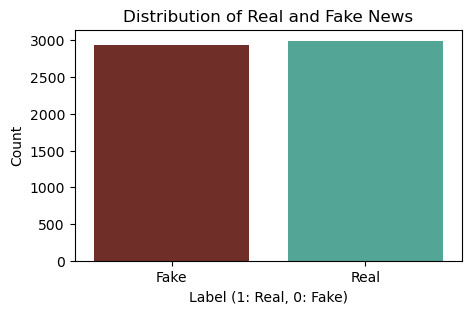

In [30]:
plt.figure(figsize=(5, 3))
sns.countplot(x='label', data=data, palette=['#7B241C', '#45b39d'])  
plt.title('Distribution of Real and Fake News')
plt.xlabel('Label (1: Real, 0: Fake)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

- Data is well balanced

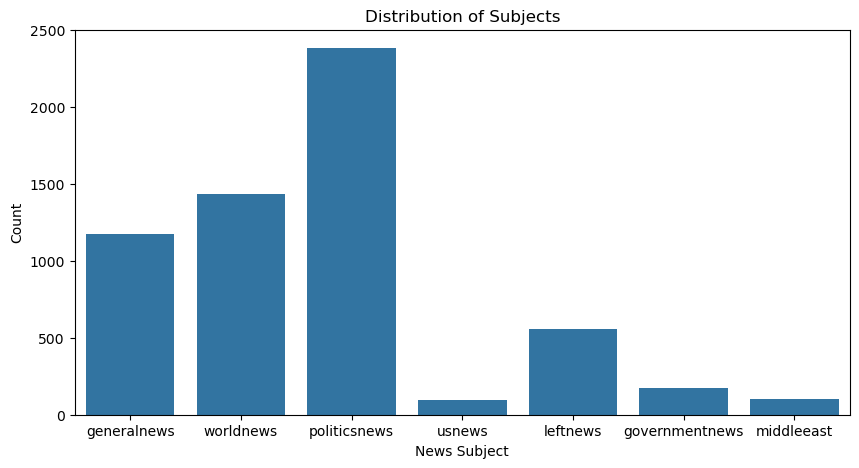

In [31]:
plt.figure(figsize=(10,5))
sns.countplot(x='cleaned_subject', data=data)  
plt.title('Distribution of Subjects')
plt.xlabel('News Subject')
plt.ylabel('Count')
plt.show()

- It appeares that the data consists mostly of politics news
- The data doesnt contain much governmentnews
- without knowing what sort of news are the general,us,left,middeleast news we cant say that the data is based on politics

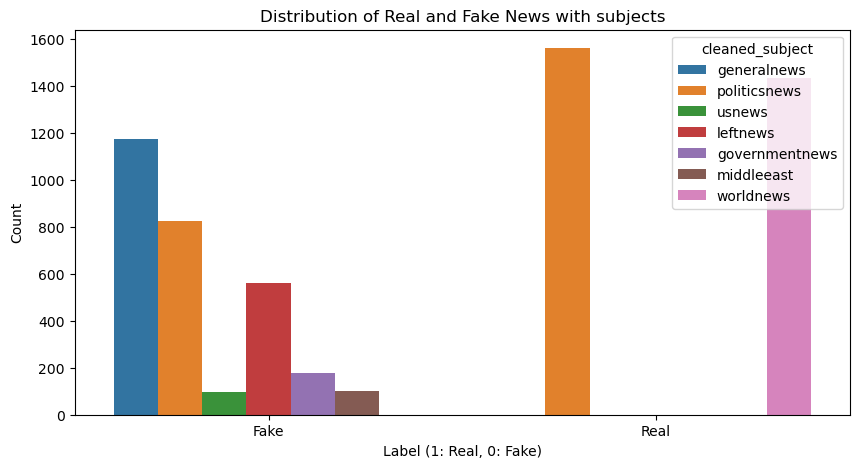

In [32]:
plt.figure(figsize=(10,5))
sns.countplot(x='label',hue='cleaned_subject', data=data)  
plt.title('Distribution of Real and Fake News with subjects')
plt.xlabel('Label (1: Real, 0: Fake)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

- Real news only come from world and political news
- Fake news doesnt come from world news
- Most of fake news come from general news

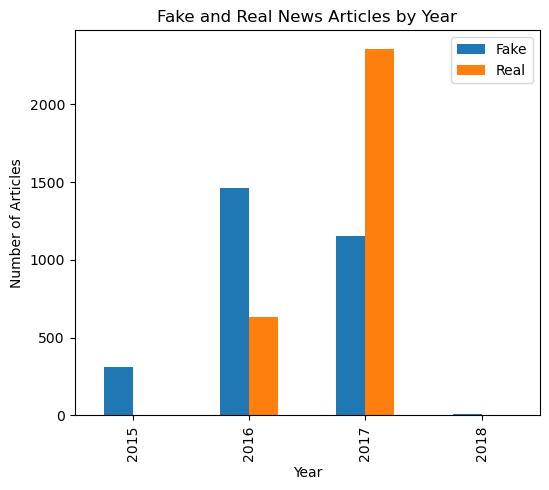

In [33]:
data.groupby([data['date'].dt.year, 'label']).size().unstack(fill_value=0).plot(kind='bar', figsize=(6, 5))

plt.title('Fake and Real News Articles by Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend(['Fake', 'Real'])
plt.show()

- The data contains articles from 2015 to 2018
- 2017 was the year with most articles released
- In 2017 the real articles published were double the fake ones
- in 2015 and 2018 only fake articles were published

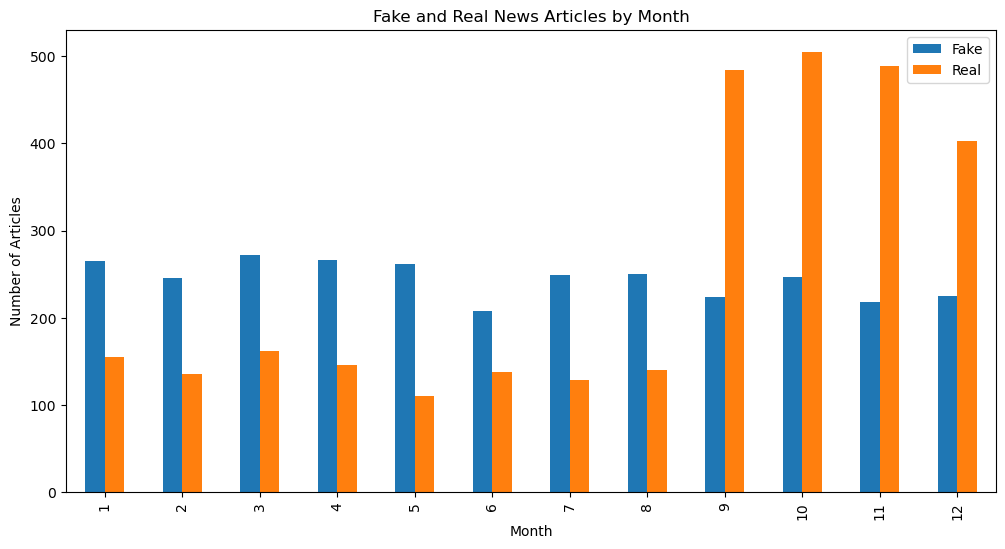

In [34]:
data.groupby([data['date'].dt.month, 'label']).size().unstack(fill_value=0).plot(kind='bar', figsize=(12, 6))

plt.title('Fake and Real News Articles by Month')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.legend(['Fake', 'Real'])
plt.show()

- Articles tend to be Published more in the last monthes of the year
- October had the most Articles puvlished

- ### Calculating positive and negative words in TEXT AND TITLE columns 

In [35]:
textual_data=[ 'cleaned_title', 'cleaned_text','cleaned_subject']

In [36]:
def count_positive(text):
    positive_words = r'\b(good|excellent|amazing|love|fantastic|great|recommend)\b'
    return len(re.findall(positive_words, text, re.IGNORECASE))

def count_negative(text):
    negative_words = r'\b(bad|poor|terrible|worst|hate|disappoint|awful)\b'
    return len(re.findall(negative_words, text, re.IGNORECASE))

In [37]:
# Apply count_positive 
data['positive_count'] = data[textual_data].apply(
    lambda row: count_positive(' '.join([str(x) for x in row])),
    axis=1)

# Apply count_negative
data['negative_count'] = data[textual_data].apply(
    lambda row: count_negative(' '.join([str(x) for x in row])),
    axis=1)

In [38]:
data.head(5)

,cleaned_title,cleaned_subject,cleaned_text,date,label,positive_count,negative_count
0,watch trump told antigay bigot mike penny go fck,generalnews,whole lot evangelical trump voter discovered g...,2016-11-13,0,0,1
1,china back un call justice yemen u saudi dont,worldnews,geneva reuters china signaled wednesday willin...,2017-09-13,1,0,1
2,wsj reporter rip dem candidate lame rhetoric i...,politicsnews,wsj mary kissel nail dem debate three candidat...,2015-11-15,0,0,0
3,lawmaker aim delay u ceding control internet m...,politicsnews,washington reuters critic plan u government ce...,2016-09-13,1,0,0
4,trump stranded full panic another performer dr...,generalnews,presidentelect donald trump trouble finding pe...,2017-01-16,0,1,0


In [39]:
# Create positive and negative reviews datasets
positive_reviews = data[data['positive_count'] > 0]
negative_reviews = data[data['negative_count'] > 0]
# Create neutral reviews dataset where neither positive nor negative words are present
data['neutral_count'] = (data['positive_count'] == 0) & (data['negative_count'] == 0)
neutral_reviews = data[data['neutral_count']]

# Print counts of positive and negative and neutral reviews
print(f"positive_reviews: {len(positive_reviews)}")
print(f"negative_reviews: {len(negative_reviews)}")
print(f"neutral_reviews: {len(neutral_reviews)}")

positive_reviews: 1536
negative_reviews: 1039
neutral_reviews: 3793


- Creating Sentiment column to visualize distribution of News whether thay are mostly positive or negative or neutral

In [40]:
#Prep for visualization
def categorize_sentiment(row):
    if row['positive_count'] > row['negative_count']:
        return 'positive'
    elif row['positive_count'] < row['negative_count']:
        return 'negative'
    else:
        return 'neutral'

In [41]:
data['sentiment'] = data.apply(categorize_sentiment, axis=1) 
data['sentiment'].unique()

array(['negative', 'neutral', 'positive'], dtype=object)

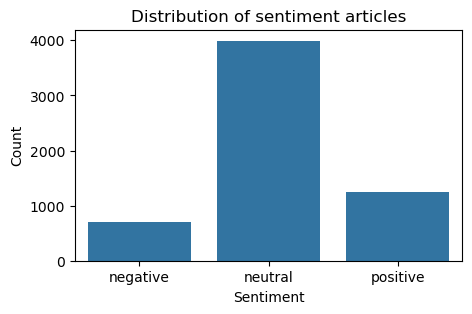

In [42]:
plt.figure(figsize=(5, 3))
sns.countplot(x='sentiment', data=data)  
plt.title('Distribution of sentiment articles')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

- The dataset contains mostly neutral articles

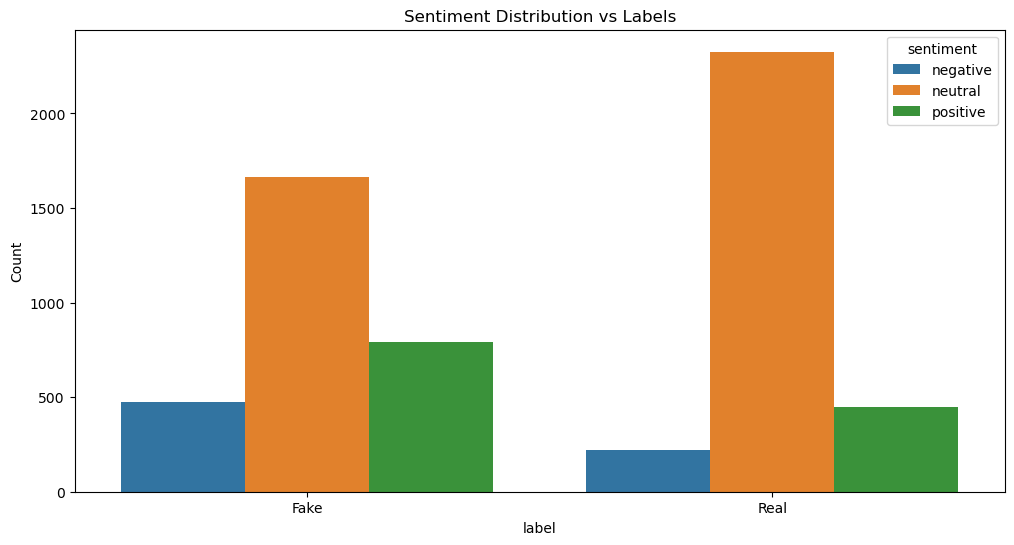

In [43]:
plt.figure(figsize=(12, 6))
sns.countplot(x='label', hue='sentiment', data=data)
plt.title('Sentiment Distribution vs Labels')
plt.xlabel('label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

In [44]:
# Summary statistics
print(data.describe())

                                date        label  positive_count  \
count                           5927  5927.000000     5927.000000   
mean   2017-02-06 22:57:04.464315648     0.505315        0.440864   
min              2015-04-06 00:00:00     0.000000        0.000000   
25%              2016-07-23 12:00:00     0.000000        0.000000   
50%              2017-03-14 00:00:00     1.000000        0.000000   
75%              2017-09-27 00:00:00     1.000000        1.000000   
max              2018-02-19 00:00:00     1.000000       31.000000   
std                              NaN     0.500014        1.104177   

       negative_count  
count     5927.000000  
mean         0.268095  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          9.000000  
std          0.717530  


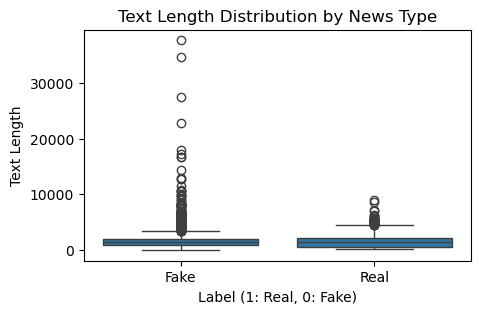

In [45]:
# Calculate text length
data['text_length'] = data['cleaned_text'].apply(len)

# Boxplot of text lengths
plt.figure(figsize=(5, 3))
sns.boxplot(x='label', y='text_length', data=data)
plt.title('Text Length Distribution by News Type')
plt.xlabel('Label (1: Real, 0: Fake)')
plt.ylabel('Text Length')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

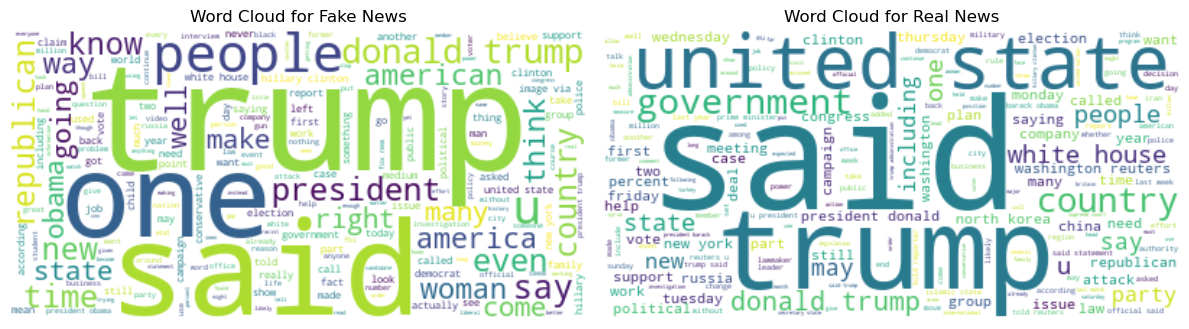

In [46]:
# Filter fake and real news based on the label column
fake_news = data[data['label'] == 0]
real_news = data[data['label'] == 1]

# Convert list of words to string for each row and then join them
fake_text = ' '.join(fake_news['cleaned_text'])
real_text = ' '.join(real_news['cleaned_text'])

# Generate word clouds
wordcloud_fake = WordCloud(width=400, height=200, background_color='white').generate(fake_text)
wordcloud_real = WordCloud(width=400, height=200, background_color='white').generate(real_text)

plt.figure(figsize=(12, 6))

# Plotting the fake news word cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fake News')

# Plotting the real news word cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Real News')

plt.tight_layout()
plt.show()


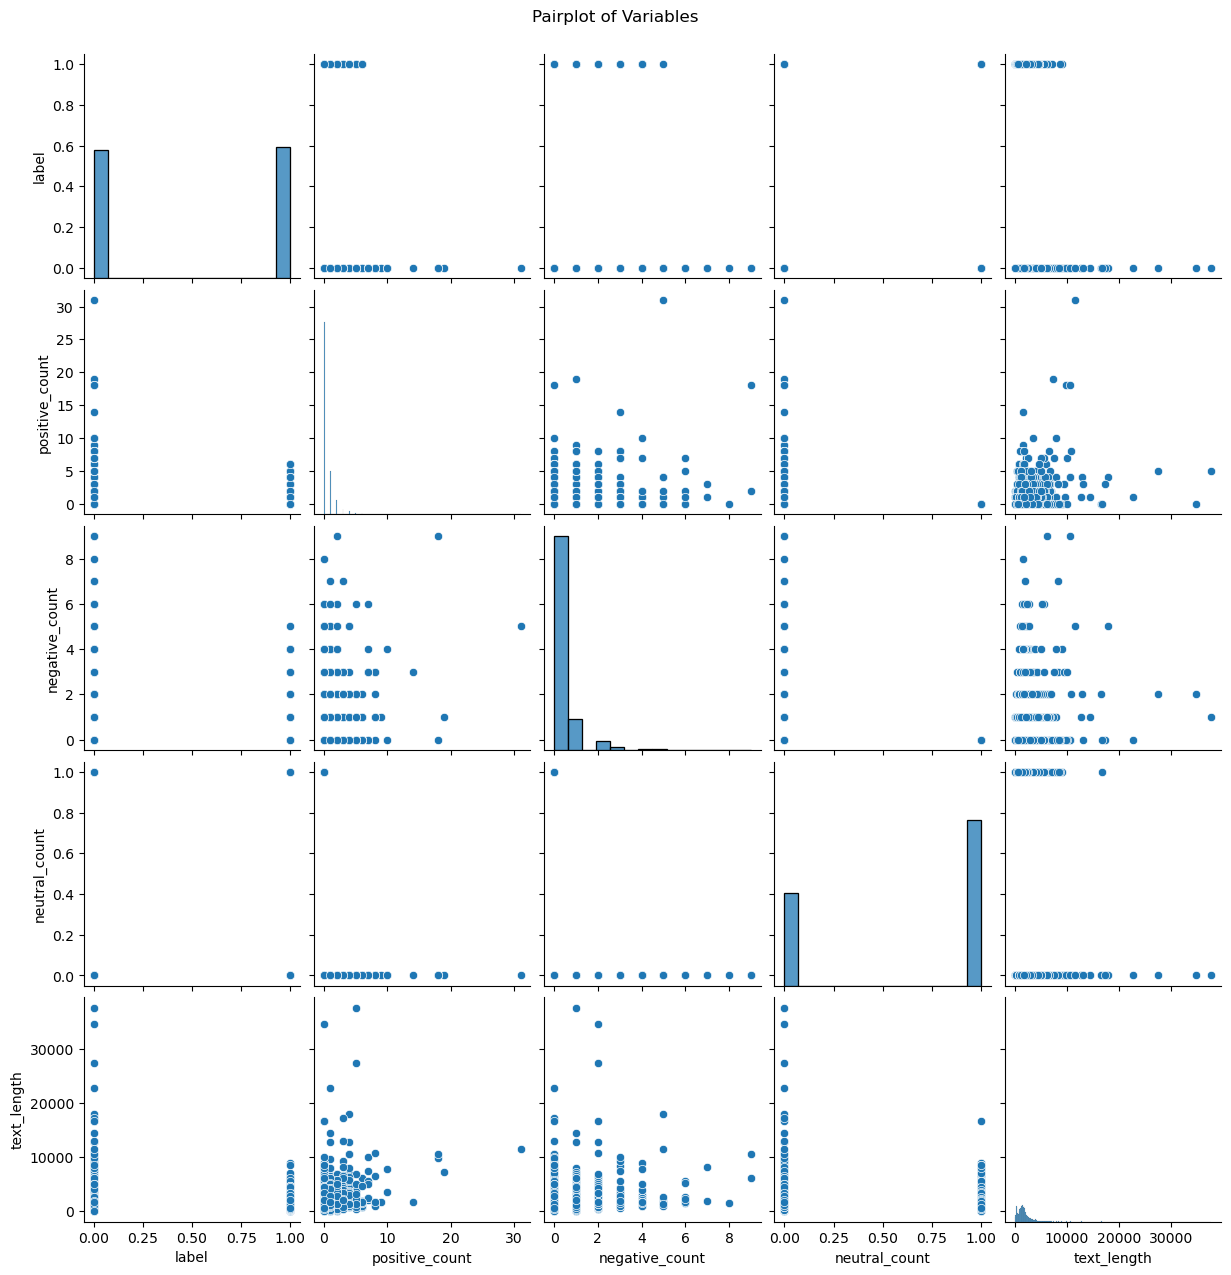

In [47]:
# Create a pairplot
sns.pairplot(data)
plt.suptitle('Pairplot of Variables', y=1.02)
plt.show()

In [48]:
# Calculate word counts for cleaned title & text
data['cleaned_title_word_count'] = data['cleaned_title'].apply(lambda x: len(x.split()))  
data['cleaned_text_word_count'] = data['cleaned_text'].apply(lambda x: len(x.split()))

# Average word count for cleaned title & text
print("Average cleaned title word count:", data['cleaned_title_word_count'].mean())
print("Average cleaned text word count:", data['cleaned_text_word_count'].mean())

Average cleaned title word count: 9.229964568921883
Average cleaned text word count: 230.5093639277881


# Similarities

In [49]:
# Separate real and fake news
real_news = data[data['label'] == 1]['cleaned_text']
fake_news = data[data['label'] == 0]['cleaned_text']

# Combine data for vectorization
all_news = pd.concat([real_news, fake_news])

In [50]:
# Vectorize the text data to be numerical using tfidf
vectorizer = TfidfVectorizer()
vectorizer

TfidfVectorizer()

In [51]:
tfidf_matrix = vectorizer.fit_transform(all_news)
tfidf_matrix

<5927x63752 sparse matrix of type '<class 'numpy.float64'>'
	with 938757 stored elements in Compressed Sparse Row format>

In [52]:
# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

# Analyze similarity of the first real news article with all articles
similarity_with_first_real = cosine_sim[0]  # Adjust index for the article you want to analyze

# Display the similarity scores
print(f"Cosine Similarity of the first real news article with all articles:\n{similarity_with_first_real}")

Cosine Similarity of the first real news article with all articles:
[1.         0.04080565 0.03367334 ... 0.02313037 0.02069948 0.03606399]


In [53]:
# Function to compute Jaccard similarity
def jaccard_similarity(str1, str2):
    a = set(str1.split())
    b = set(str2.split())
    return len(a.intersection(b)) / len(a.union(b))

In [54]:
# Calculate Jaccard similarity for the first real news article with fake articles
first_real_article = real_news.iloc[0]
jaccard_similarities = [jaccard_similarity(first_real_article, fake) for fake in fake_news]

# Display Jaccard similarities
print(f"Jaccard Similarities with the first real news article:\n{jaccard_similarities}")

Jaccard Similarities with the first real news article:
[0.03908794788273615, 0.019011406844106463, 0.047752808988764044, 0.0, 0.08045977011494253, 0.03353658536585366, 0.05370843989769821, 0.044270833333333336, 0.048582995951417005, 0.053445850914205346, 0.05172413793103448, 0.025078369905956112, 0.02702702702702703, 0.056847545219638244, 0.049689440993788817, 0.05345911949685535, 0.009523809523809525, 0.03322259136212625, 0.024489795918367346, 0.04242424242424243, 0.04516129032258064, 0.039100684261974585, 0.043859649122807015, 0.05232558139534884, 0.034129692832764506, 0.03903903903903904, 0.041811846689895474, 0.052109181141439205, 0.032362459546925564, 0.03125, 0.03260869565217391, 0.05042016806722689, 0.0576036866359447, 0.02413793103448276, 0.049217002237136466, 0.03643724696356275, 0.04891304347826087, 0.04779411764705882, 0.0705521472392638, 0.025362318840579712, 0.04087193460490463, 0.04943820224719101, 0.03481012658227848, 0.02909090909090909, 0.0436241610738255, 0.0, 0.01587

# Machine Learning

In [55]:
x = data['cleaned_text']
y= data['label']
x

0       whole lot evangelical trump voter discovered g...
1       geneva reuters china signaled wednesday willin...
2       wsj mary kissel nail dem debate three candidat...
3       washington reuters critic plan u government ce...
4       presidentelect donald trump trouble finding pe...
                              ...                        
5922    santiago reuters group oppositionappointed ven...
5923    nairobi reuters outbreak plague killed people ...
5924    washington reuters donald trump travel asia no...
5925    reuters melania trump rose husband defense mon...
5926    bill penzey owner penzeys spice wrote two sepa...
Name: cleaned_text, Length: 5927, dtype: object

In [56]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [57]:
print('train data:',x_train.shape)
print('test data:',x_test.shape)

train data: (4741,)
test data: (1186,)


In [58]:
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf= vectorizer.transform(x_test)

In [59]:
print('train tfidf data:',x_train_tfidf.shape)
print('test tfidf data:',x_test_tfidf.shape)

train tfidf data: (4741, 55850)
test tfidf data: (1186, 55850)


In [60]:
def gridSearch(model, param, x_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

# Logistic Regression

In [61]:
param_grid = {
    # REgularization Parameter
    'C': [0.01, 0.1, 1, 10, 100],
    # Algorithm to use in the optimization problem.
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    # Maximum number of iterations taken for the solvers to converge.
    'max_iter': [100, 200, 300]
}

In [62]:
Logistic_model = LogisticRegression(C= 100, max_iter= 100, solver= 'newton-cg')

In [63]:
# gridSearch(Logistic_model, param_grid ,x_train_tfidf,y_train)

In [64]:
Logistic_model.fit(x_train_tfidf, y_train)

LogisticRegression(C=100, solver='newton-cg')

In [65]:
y_pred_train= Logistic_model.predict(x_train_tfidf)
y_pred_test = Logistic_model.predict(x_test_tfidf)

In [66]:
print("Classification Report For logistic Regression:")
print("1-For Train Data:")
print("a-Accuracy Score:",accuracy_score(y_train, y_pred_train))
print("b-MSE: ",mean_squared_error(y_train,y_pred_train))
print(classification_report(y_train, y_pred_train))
print("---------------------")
print("2-For Test Data:")
print("a-Accuracy Score:",accuracy_score(y_test, y_pred_test))
print("b-MSE: ",mean_squared_error(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Classification Report For logistic Regression:
1-For Train Data:
a-Accuracy Score: 1.0
b-MSE:  0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2368
           1       1.00      1.00      1.00      2373

    accuracy                           1.00      4741
   macro avg       1.00      1.00      1.00      4741
weighted avg       1.00      1.00      1.00      4741

---------------------
2-For Test Data:
a-Accuracy Score: 0.9780775716694773
b-MSE:  0.021922428330522766
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       564
           1       0.98      0.98      0.98       622

    accuracy                           0.98      1186
   macro avg       0.98      0.98      0.98      1186
weighted avg       0.98      0.98      0.98      1186



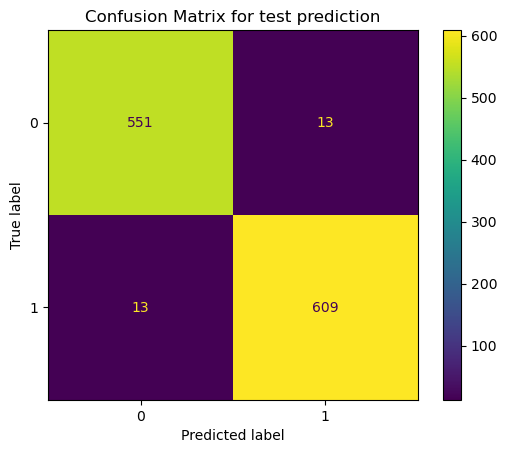

In [67]:
ConfusionMatrixDisplay.from_estimator(Logistic_model, x_test_tfidf, y_test)
plt.title("Confusion Matrix for test prediction")
plt.show()

## PCA logistic Regression to see a graph 

In [68]:
def pcafunc(n):
    pca = PCA(n_components=n)
    x_train_pca = pca.fit_transform(x_train_tfidf.toarray())
    x_test_pca = pca.transform(x_test_tfidf.toarray())
    model = LogisticRegression()
    model.fit(x_train_pca, y_train)
    y_pred_train= model.predict(x_train_pca)
    y_pred_test = model.predict(x_test_pca)
    return {
        'x_train_pca': x_train_pca,
        'x_test_pca': x_test_pca, 
        'model': model,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'test_accuracy': accuracy_score(y_test, y_pred_test)}
    

In [69]:
pca_result = pcafunc(2)
pca_result

{'x_train_pca': array([[ 0.06366163,  0.07118027],
        [ 0.14099767, -0.02339889],
        [-0.0157016 , -0.10854969],
        ...,
        [ 0.13796114, -0.01695392],
        [ 0.07173307, -0.01538419],
        [ 0.02340017,  0.00605651]]),
 'x_test_pca': array([[ 0.05115802,  0.00655194],
        [-0.05348777, -0.05846446],
        [ 0.11784968, -0.08673001],
        ...,
        [-0.04764199, -0.08089636],
        [-0.04467173, -0.00976959],
        [-0.0263235 ,  0.05453055]]),
 'model': LogisticRegression(),
 'y_pred_train': array([1, 0, 0, ..., 0, 0, 1], dtype=int64),
 'y_pred_test': array([0, 0, 0, ..., 0, 1, 1], dtype=int64),
 'train_accuracy': 0.8354777473106939,
 'test_accuracy': 0.8322091062394603}

In [70]:
x_train_pca = pca_result['x_train_pca']
model = pca_result['model']

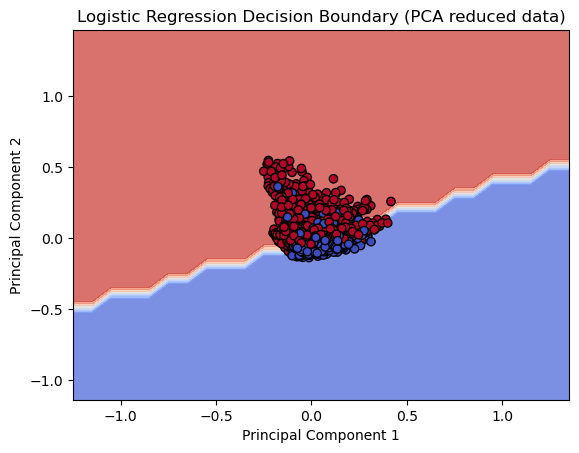

In [71]:
# PC1 and PC2 are the new feutures created by compressing all the feutures
# Creating the mexh grid (Its the grid of points used to create the decision boundry)
# To create it i need to:
# 1- find the max and min points of component1 (x) 
x_min, x_max = x_train_pca[:, 0].min() - 1, x_train_pca[:, 0].max() + 1
# 2- find the max and min points of component2 (y) 
y_min, y_max = x_train_pca[:, 1].min() - 1, x_train_pca[:, 1].max() + 1
# 3- creating 2 arrays using max and min values for both pc 1 & 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Creating the decision Boundry:
# 1- Getting label predictions for all grid points
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# 2- Ploting the decision boundary
plt.contourf(xx, yy, Z, alpha=0.75, cmap='coolwarm')

# Ploting the training points
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train, edgecolors='k', marker='o', cmap='coolwarm')

plt.title('Logistic Regression Decision Boundary (PCA reduced data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [72]:
pcafunc(10)

{'x_train_pca': array([[ 0.06366579,  0.07114568,  0.03824983, ...,  0.10870923,
          0.08908   , -0.05401839],
        [ 0.14099466, -0.02340525, -0.09427645, ..., -0.0233984 ,
         -0.01750417, -0.02687378],
        [-0.01570313, -0.10852684, -0.05951331, ...,  0.01766267,
         -0.0525781 ,  0.03087355],
        ...,
        [ 0.13796911, -0.01697494, -0.02673772, ...,  0.11014871,
          0.03442379,  0.14138877],
        [ 0.07173392, -0.01538346, -0.03467451, ...,  0.02031053,
          0.04335148,  0.07021291],
        [ 0.0234039 ,  0.0060598 , -0.01675508, ...,  0.01556622,
          0.02663301,  0.03253549]]),
 'x_test_pca': array([[ 0.05115421,  0.0065404 , -0.01610955, ...,  0.00184617,
          0.0235536 , -0.08369281],
        [-0.0534842 , -0.05846948,  0.07169909, ...,  0.02131418,
          0.04182874,  0.04759801],
        [ 0.11785413, -0.08674057, -0.06606863, ...,  0.04376357,
         -0.01007988,  0.08105614],
        ...,
        [-0.04764393, -0.

In [73]:
pcafunc(30)

{'x_train_pca': array([[ 0.06366683,  0.07114667,  0.03827134, ...,  0.02233383,
          0.00592177,  0.02819551],
        [ 0.14099447, -0.02340952, -0.09425498, ...,  0.00315116,
         -0.00823512, -0.03668216],
        [-0.0157048 , -0.10853484, -0.05948171, ...,  0.06314075,
         -0.0507234 ,  0.07280137],
        ...,
        [ 0.13796855, -0.01697731, -0.02673971, ...,  0.0192788 ,
         -0.01629729,  0.01128704],
        [ 0.07173387, -0.0153864 , -0.03467745, ...,  0.00976428,
         -0.01286002, -0.03848341],
        [ 0.02340367,  0.00606109, -0.01678553, ...,  0.03632938,
         -0.1755496 ,  0.00510401]]),
 'x_test_pca': array([[ 0.051156  ,  0.00653813, -0.01605767, ..., -0.0069447 ,
          0.05248847, -0.01504027],
        [-0.05348524, -0.05847377,  0.07172289, ..., -0.0620862 ,
          0.05501139, -0.02059654],
        [ 0.11785392, -0.08674105, -0.0660608 , ..., -0.00566602,
          0.00635014,  0.01676751],
        ...,
        [-0.04764342, -0.

In [74]:
pcafunc(50)

{'x_train_pca': array([[ 0.06366681,  0.07114663,  0.03827115, ...,  0.01681856,
         -0.03507908,  0.00351208],
        [ 0.14099445, -0.02340954, -0.0942549 , ..., -0.00917163,
         -0.02303086, -0.03017908],
        [-0.01570489, -0.10853472, -0.05948065, ...,  0.00035528,
         -0.01783205, -0.07243571],
        ...,
        [ 0.13796838, -0.01697693, -0.02673822, ..., -0.03182186,
         -0.0330418 , -0.0128984 ],
        [ 0.07173394, -0.0153866 , -0.03467818, ..., -0.02524408,
          0.00242632,  0.01026413],
        [ 0.02340373,  0.00606058, -0.0167852 , ...,  0.03048215,
         -0.05572985,  0.01493363]]),
 'x_test_pca': array([[ 0.0511561 ,  0.00653769, -0.01605873, ...,  0.05794893,
         -0.02785658, -0.03101933],
        [-0.0534851 , -0.05847347,  0.0717237 , ...,  0.00821572,
          0.02972902, -0.05114659],
        [ 0.11785387, -0.08674117, -0.06606033, ..., -0.00261616,
         -0.03186369, -0.01707006],
        ...,
        [-0.04764347, -0.

In [75]:
pcafunc(70)

{'x_train_pca': array([[ 0.06366682,  0.07114659,  0.03827132, ...,  0.03205101,
         -0.00669539,  0.0333243 ],
        [ 0.14099445, -0.02340949, -0.09425505, ...,  0.0031721 ,
         -0.01550556, -0.03010938],
        [-0.0157049 , -0.10853467, -0.05948092, ..., -0.03698362,
          0.05554938, -0.05101592],
        ...,
        [ 0.13796837, -0.01697703, -0.02673783, ..., -0.05402907,
          0.09323813, -0.05011559],
        [ 0.07173395, -0.01538651, -0.0346782 , ...,  0.01201307,
          0.00358827,  0.0492757 ],
        [ 0.02340373,  0.00606066, -0.01678548, ..., -0.00294355,
         -0.05255945, -0.01708013]]),
 'x_test_pca': array([[ 0.05115611,  0.00653775, -0.01605891, ..., -0.02725128,
          0.04722763,  0.0192973 ],
        [-0.05348509, -0.05847339,  0.07172365, ...,  0.02751278,
         -0.00324814,  0.0145972 ],
        [ 0.11785387, -0.08674117, -0.06606029, ..., -0.00377949,
          0.02274472, -0.00886075],
        ...,
        [-0.04764346, -0.

# Random Forest Model

In [76]:
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for better performance
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)



In [77]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_tfidf, y_train)


RandomForestClassifier(random_state=42)

In [78]:
y_pred = rf_model.predict(x_test_tfidf)

In [79]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9924114671163575
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       564
           1       0.99      0.99      0.99       622

    accuracy                           0.99      1186
   macro avg       0.99      0.99      0.99      1186
weighted avg       0.99      0.99      0.99      1186

Confusion Matrix:
 [[559   5]
 [  4 618]]


559 true negatives (correctly classified fake news).
5 false positives (real news misclassified as fake).
4 false negatives (fake news misclassified as real).
618 true positives (correctly classified real news).

In [80]:
feature_names = vectorizer.get_feature_names_out()
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(importance_df.sort_values(by='Importance', ascending=False).head(10))


         Feature  Importance
3800     reuters    0.156056
3901        said    0.048257
4781         via    0.022105
2630        like    0.015424
2849    minister    0.012322
4854  washington    0.011959
2200       image    0.010797
4651     tuesday    0.009440
4877   wednesday    0.008774
185      america    0.007930


In [81]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

In [82]:
# Cross-Validation
cv_scores = cross_val_score(rf_model, x_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy:", cv_scores.mean())


Cross-Validation Accuracy: 0.9911423528208685


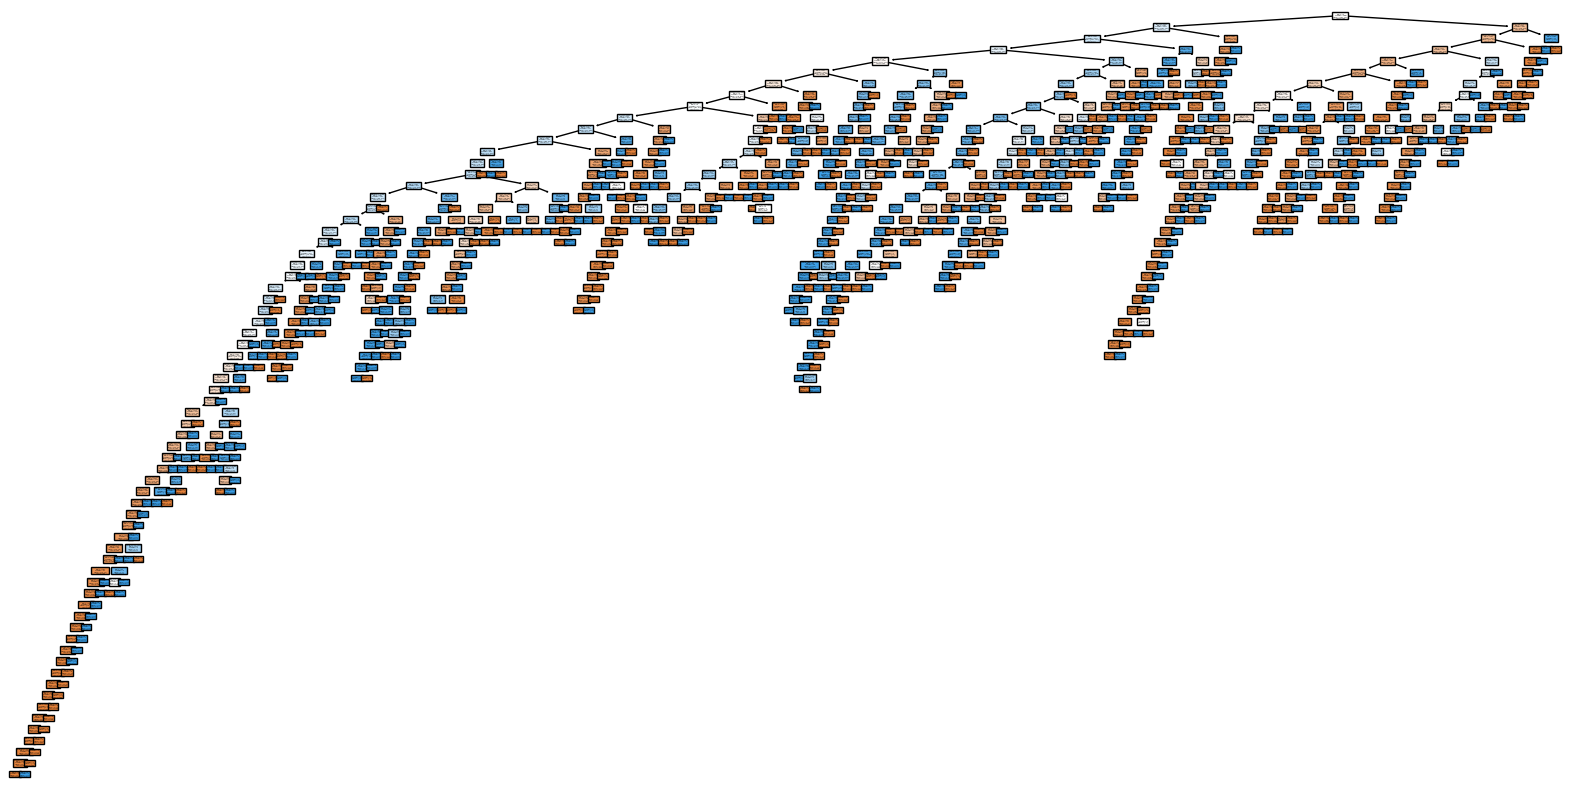

In [83]:
# x_train_tfidf and y_train are the preprocess data
# n_estimators hyper parameter
rf_model = RandomForestClassifier(random_state=42, n_estimators=10)  
rf_model.fit(x_train_tfidf, y_train)

# Extract the first tree from the forest
first_tree = rf_model.estimators_[0]


plt.figure(figsize=(20, 10)) 
plot_tree(first_tree, feature_names=vectorizer.get_feature_names_out(), class_names=['Fake', 'Real'], filled=True)
plt.show()


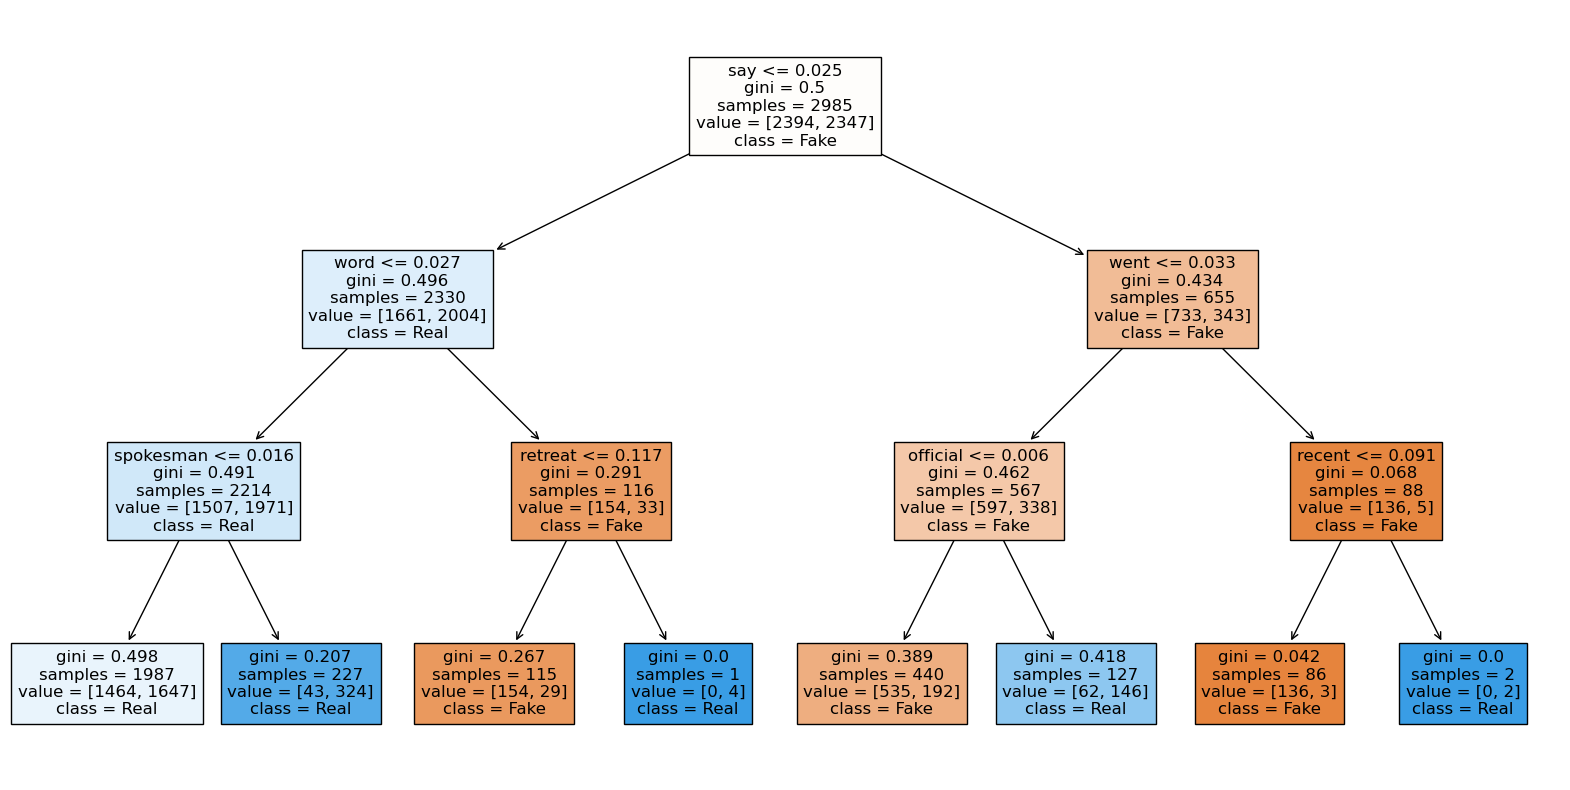

In [84]:
#  x_train_tfidf and y_train are the preprocess data
# to display the first 3 levels
rf_model = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3) 
rf_model.fit(x_train_tfidf, y_train)

# Extract the first tree from the forest
first_tree = rf_model.estimators_[0]

# Visualize the first 3 levels and setting the size
plt.figure(figsize=(20, 10)) 
plot_tree(
    first_tree,
    feature_names=vectorizer.get_feature_names_out(),
    class_names=['Fake', 'Real'],
    filled=True,
    max_depth=3 
)
plt.show()


# SVM

In [85]:
print("x_train data types:", x_train.dtypes)
print("y_train data types:", y_train.dtypes)

x_train data types: object
y_train data types: int64


In [86]:
# Fit and transform training data
x_train_tfidf = vectorizer.fit_transform(x_train)  
x_test_tfidf = vectorizer.transform(x_test)

In [87]:
#Initializes SVC with a linear kernel:
clf = SVC(kernel='linear')
#Trains the classifier:
clf.fit(x_train_tfidf, y_train)

SVC(kernel='linear')

In [88]:
# Predict on the test set
y_pred = clf.predict(x_test_tfidf)

In [89]:
misclassified = x_test[y_test != y_pred]
print("Examples of misclassified texts:\n", misclassified[:5])

Examples of misclassified texts:
 4166    new cold war saudi arabia iran going escalated...
1978    great story anyone understand power one libera...
4421    wow liberal supreme court really making view k...
2526    wrote ab want send message nation california s...
2850    london reuters britain daily mail agreed wedne...
Name: cleaned_text, dtype: object


In [90]:
#calculating accuracy:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
#Classification Report:
print("Classification Report:")
print(classification_report(y_test, y_pred))

#confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.978920741989882
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       564
           1       0.98      0.98      0.98       622

    accuracy                           0.98      1186
   macro avg       0.98      0.98      0.98      1186
weighted avg       0.98      0.98      0.98      1186

Confusion Matrix:
[[552  12]
 [ 13 609]]


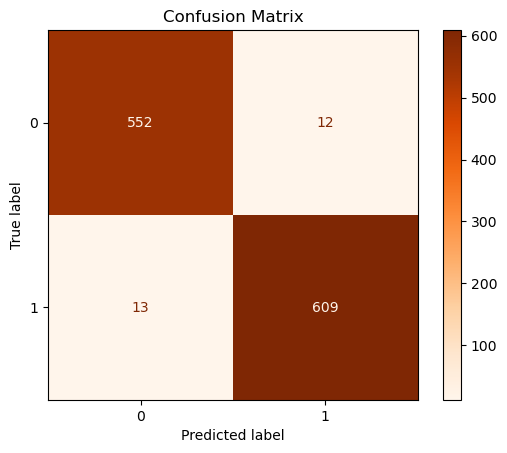

In [91]:
ConfusionMatrixDisplay.from_estimator(clf, x_test_tfidf, y_test, cmap='Oranges')
plt.title("Confusion Matrix")
plt.show()

In [92]:
#for non-linear decision boundary
svm_rbf = SVC(kernel='rbf', gamma='scale')
svm_rbf.fit(x_train_tfidf, y_train)

SVC()

In [93]:
# Predict on the test set
y_pred_rbf = svm_rbf.predict(x_test_tfidf)
#calculating accuracy:
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
print("Accuracy with RBF kernel:", accuracy_rbf)

Accuracy with RBF kernel: 0.9780775716694773


In [94]:
misclassified = x_test[y_test != y_pred_rbf]
print("Examples of misclassified texts:\n", misclassified[:5])

Examples of misclassified texts:
 4166    new cold war saudi arabia iran going escalated...
1978    great story anyone understand power one libera...
4421    wow liberal supreme court really making view k...
2526    wrote ab want send message nation california s...
2850    london reuters britain daily mail agreed wedne...
Name: cleaned_text, dtype: object


In [95]:
#Classification Report:
print("Classification Report:")
print(classification_report(y_test, y_pred_rbf))

#confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rbf))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       564
           1       0.98      0.98      0.98       622

    accuracy                           0.98      1186
   macro avg       0.98      0.98      0.98      1186
weighted avg       0.98      0.98      0.98      1186

Confusion Matrix:
[[550  14]
 [ 12 610]]


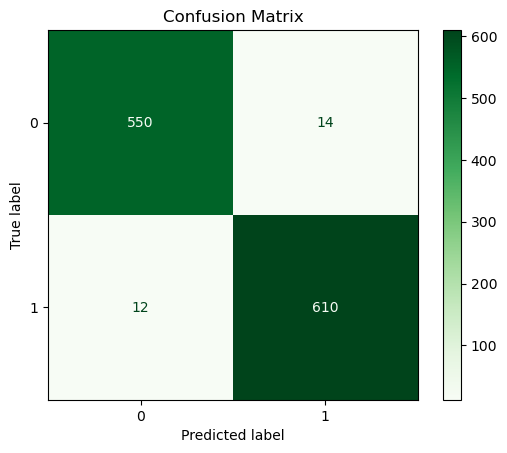

In [96]:
ConfusionMatrixDisplay.from_estimator(svm_rbf, x_test_tfidf, y_test, cmap='Greens')
plt.title("Confusion Matrix")
plt.show()

In [112]:
#Define an SVM model with regularization
svm_model = SVC(C=0.1, kernel='rbf')
svm_model.fit(x_train_tfidf, y_train)

SVC(C=0.1)

In [113]:
# Predict on the test set
y_pred_3 = svm_model.predict(x_test_tfidf)
#calculating accuracy:
accuracy_rbf = accuracy_score(y_test, y_pred_3)
print("Accuracy with RBF kernel:", accuracy_rbf)

Accuracy with RBF kernel: 0.9502529510961214


In [100]:
misclassified = x_test[y_test != y_pred_3]
print("Examples of misclassified texts:\n", misclassified[:5])

Examples of misclassified texts:
 2722    washington reuters u conservative activist phy...
1406    kansa city mobloomington ill reuters donald tr...
604     following statement posted verified twitter ac...
5516    donald trump may decided russia going america ...
4166    new cold war saudi arabia iran going escalated...
Name: cleaned_text, dtype: object


In [101]:
#Classification Report:
print("Classification Report:")
print(classification_report(y_test, y_pred_3))

#confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_3))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       564
           1       0.95      0.95      0.95       622

    accuracy                           0.95      1186
   macro avg       0.95      0.95      0.95      1186
weighted avg       0.95      0.95      0.95      1186

Confusion Matrix:
[[536  28]
 [ 31 591]]


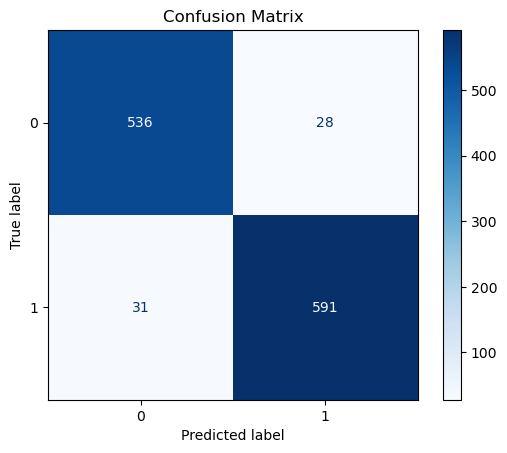

In [102]:
ConfusionMatrixDisplay.from_estimator(svm_model, x_test_tfidf, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# PCA SVM:

In [103]:
# Reduce the dimensionality of the TF-IDF matrix to 2 components
pca = PCA(n_components=2, random_state=42)
x_train_pca = pca.fit_transform(x_train_tfidf.toarray())
x_test_pca = pca.transform(x_test_tfidf.toarray())

print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.01281047 0.00976963]


In [104]:
svm_pca_model = SVC(kernel='linear', C=1, random_state=42)
svm_pca_model.fit(x_train_pca, y_train)

# Predict on the test set
y_pred_pca = svm_pca_model.predict(x_test_pca)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_57564\2931153920.py:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_test, edgecolor='k', cmap=plt.cm.coolwarm, marker='x', label="Test data")


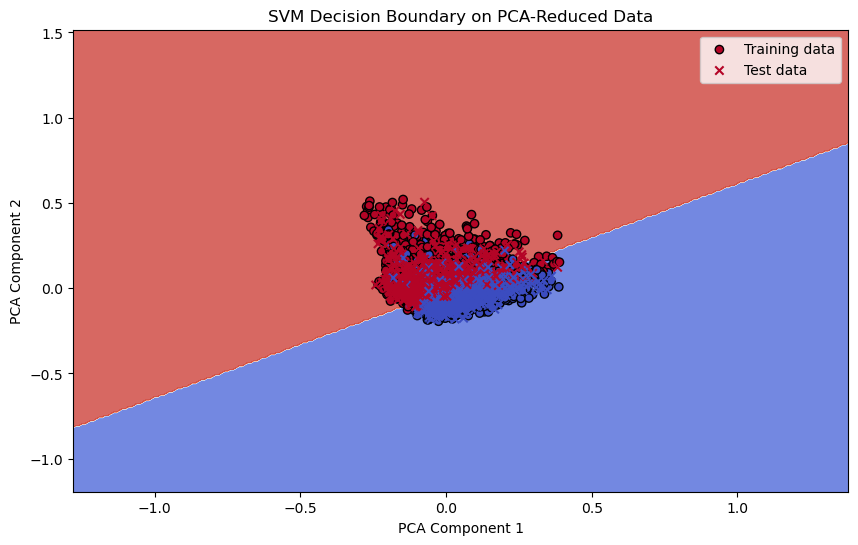

In [105]:
# Create a mesh grid
x_min, x_max = x_train_pca[:, 0].min() - 1, x_train_pca[:, 0].max() + 1
y_min, y_max = x_train_pca[:, 1].min() - 1, x_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict the SVM output for each point on the grid
Z = svm_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train, edgecolor='k', cmap=plt.cm.coolwarm, label="Training data")
plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_test, edgecolor='k', cmap=plt.cm.coolwarm, marker='x', label="Test data")

plt.title("SVM Decision Boundary on PCA-Reduced Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(loc="best")
plt.show()

# cosine similarity:

In [106]:
# Vectorize the fake and real news text
tfidf = TfidfVectorizer()
fake_tfidf = tfidf.fit_transform(fake_news)
real_tfidf = tfidf.transform(real_news)


In [107]:
# Compute pairwise cosine similarity between fake and real news articles
pairwise_sim = cosine_similarity(fake_tfidf, real_tfidf)

# Find the pair with the highest similarity
most_similar_pair = np.unravel_index(np.argmax(pairwise_sim, axis=None), pairwise_sim.shape)
fake_index, real_index = most_similar_pair

print(f"The most similar fake news article is at index {fake_index}.")
print(f"The most similar real news article is at index {real_index}.")
print(f"Cosine Similarity Score: {pairwise_sim[fake_index, real_index]:.4f}")

# Display the content of the most similar articles
print("\nMost Similar Fake News Article:\n", fake_short['text'].iloc[fake_index])
print("\nMost Similar Real News Article:\n", real_short['text'].iloc[real_index])

The most similar fake news article is at index 1103.
The most similar real news article is at index 734.
Cosine Similarity Score: 0.6720

Most Similar Fake News Article:
 Yesterday, Trae Crowder, otherwise known as the Liberal Redneck, released an awesome YouTube comedy segment celebrating the demise of Ted Cruz.After his devastating loss in Indiana on May 3, Cruz solemnly resigned from the republican presidential primary race. While a few of his supporters booed at the announcement, the overwhelming majority of Americans were anything but sad to see Cruz drop out.Crowder devoted a short segment to the topic, beginning his monologue by announcing that  everyone s favorite murder-lizard has dropped out of the race. He goes on to recite the story of how Ted Cruz came to run for president, explaining: The Cruz family spent hours praying about about whether or not he should run, until god came down and spoke to his wife directly and said he should. Continuing with the story, he says  and s

In [108]:
# Find the maximum similarity for each fake news article with any real news article
max_similarities = pairwise_sim.max(axis=1)

# Compute the average similarity
average_similarity = max_similarities.mean()
print(f"Average Maximum Similarity between Fake and Real News Articles: {average_similarity:.4f}")

Average Maximum Similarity between Fake and Real News Articles: 0.2291


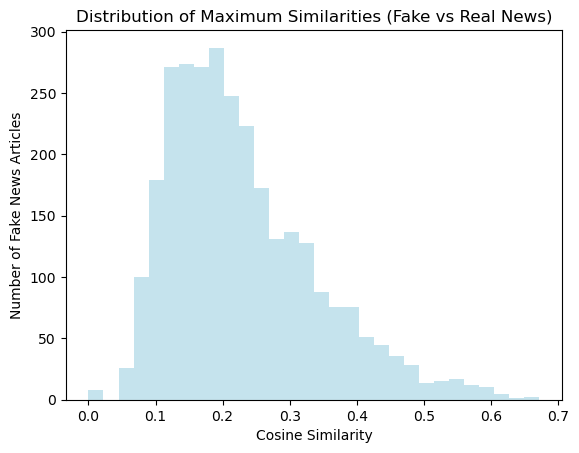

In [109]:
# Plot the distribution of maximum similarities to visualize how much overlap exists between fake and real news datasets.
plt.hist(max_similarities, bins=30, color='lightblue', alpha=0.7)
plt.title("Distribution of Maximum Similarities (Fake vs Real News)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Fake News Articles")
plt.show()